# Mean Force Integration

Import HILLS and COLVAR files, compute the mean force and integrate using the pyMFI (would be) module. 

In [2]:
import os
import numpy as np
from pyMFI import MFI
from pyMFI import run_plumed
import pickle
import matplotlib.pyplot as plt

results_path = "/home/antoniu/Desktop/MFI_git/MFI/results_plot"
path_data = "/home/antoniu/Desktop/MFI_git/MFI/AlanineDipeptide_pyMFI"

path = os.getcwd()
print("The path to this notebook is:", path)

The path to this notebook is: /home/antoniu/Desktop/MFI_git/MFI


### 2D - Periodic CV space example - Alanine Dipeptide. 

Total no. of Gaussians analysed: 5000
|500/5000|==> Average Mean Force Error: 46.65904414660994
|1000/5000|==> Average Mean Force Error: 48.16160798980814
|1500/5000|==> Average Mean Force Error: 43.41515206919667
|2000/5000|==> Average Mean Force Error: 28.600596080344346
|2500/5000|==> Average Mean Force Error: 23.58488640937739
|3000/5000|==> Average Mean Force Error: 21.463651434526263
|3500/5000|==> Average Mean Force Error: 21.430231786072557
|4000/5000|==> Average Mean Force Error: 19.997524075273112
|4500/5000|==> Average Mean Force Error: 17.337100301778648
|5000/5000|==> Average Mean Force Error: 17.267803847638458


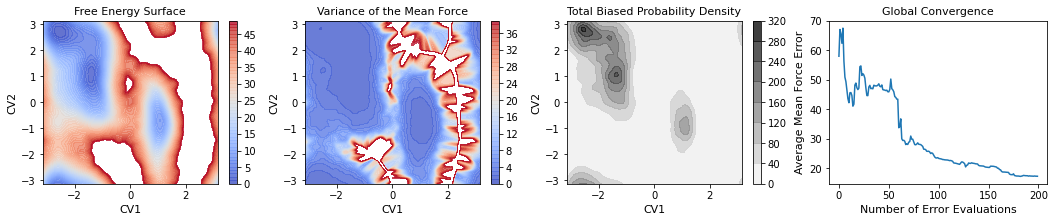

In [8]:
os.chdir(path)
os.chdir("AlanineDipeptide_pyMFI")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, log_pace = 10, error_pace = 200, WellTempered=1, nhills=5000, periodic=1)

#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history)

In [9]:
# Save Force terms
Ftot_master = [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y]
with open(results_path + "/alanine_dipeptide_1sim.pkl","wb") as fw:
    pickle.dump(Ftot_master, fw)

## Alanine Dipeptide - Run 2nd simulation and patch with 1st

In [10]:
#Load force terms
Ftot_master = []
with open(results_path + "/alanine_dipeptide_1sim.pkl", "rb") as fr:
    Ftot_master.append(pickle.load(fr))

[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = Ftot_master[0]

master = [[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]]
ofe_history_patch = [ofe_history]

In [11]:
os.chdir(path_data)

simulation_steps = 500000

#Run Alanine dipeptide simulation
run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49,
                   gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=3, biasfactor=10, 
                   gaus_pace=100, position_pace=0)


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path_data + "/HILLS")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path_data + "/position")

Running Alanine Dipeptide simulation
... Simulation finished.



Total no. of Gaussians analysed: 5000
|500/5000|==> Average Mean Force Error: 17.159931480506245
|1000/5000|==> Average Mean Force Error: 17.041379068324108
|1500/5000|==> Average Mean Force Error: 17.042996016758966
|2000/5000|==> Average Mean Force Error: 16.96903656738362
|2500/5000|==> Average Mean Force Error: 15.930540987934018
|3000/5000|==> Average Mean Force Error: 15.648239212450115
|3500/5000|==> Average Mean Force Error: 14.89152106841605
|4000/5000|==> Average Mean Force Error: 13.767338267213843
|4500/5000|==> Average Mean Force Error: 13.740136048211163
|5000/5000|==> Average Mean Force Error: 13.319786603820825


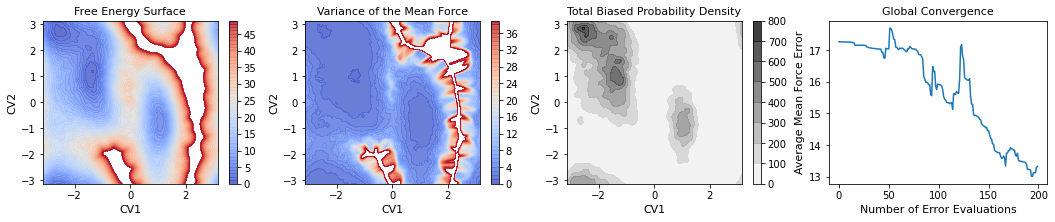

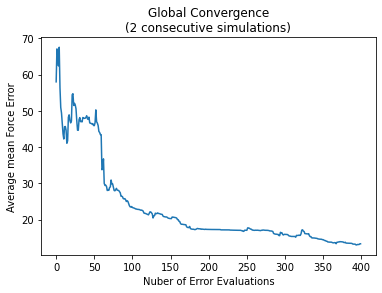

In [12]:
# Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, min_grid=np.array((-np.pi, -np.pi)), \
           max_grid=np.array((np.pi, np.pi)), nbins=np.array((200, 200)), log_pace = 10, error_pace = 200, WellTempered=1, nhills=-1, periodic=1,
           base_terms = master[0])

#store results in master_array
master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
#patch and store result in master_patch_array
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y] = MFI.patch_2D(master)
#save ofe history
ofe_history_patch.append(ofe_history)



#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)),
                nbins=np.array((200, 200)))

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history)
plt.show()

ofe_hist_new = []
for i in range(len(ofe_history_patch)):
    ofe_hist_new += ofe_history_patch[i]
plt.plot(range(len(ofe_hist_new)), ofe_hist_new)
plt.title("Global Convergence\n(2 consecutive simulations)")
plt.xlabel("Nuber of Error Evaluations")
plt.ylabel("Average mean Force Error")
plt.show()


## Alanine Dipeptide - Run 2nd simulation with static potential and patch with 1st

Preparing new input files ...
Running Alanine Dipeptide simulation
... Simulation finished.

Total no. of Gaussians analysed: 2000
|200/2000|==> Average Mean Force Error: 16.05105345105589
|400/2000|==> Average Mean Force Error: 15.049123056698699
|600/2000|==> Average Mean Force Error: 14.532812341014255
|800/2000|==> Average Mean Force Error: 14.384957304298348
|1000/2000|==> Average Mean Force Error: 14.262987343266518
|1200/2000|==> Average Mean Force Error: 13.999391170549274
|1400/2000|==> Average Mean Force Error: 13.899040130901588
|1600/2000|==> Average Mean Force Error: 13.774789906891598
|1800/2000|==> Average Mean Force Error: 13.779168994356134
|2000/2000|==> Average Mean Force Error: 13.703468724129387


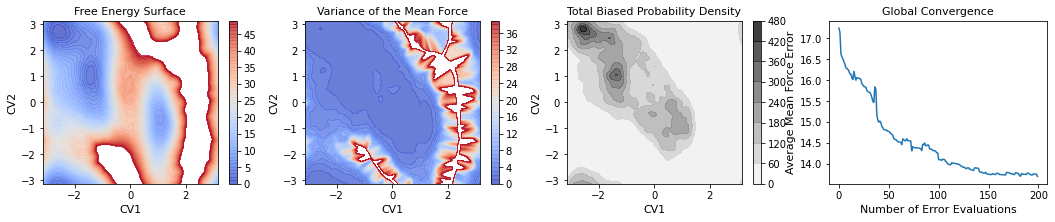

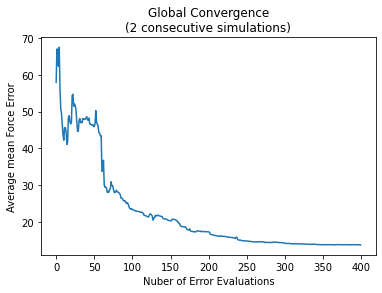

In [19]:
os.chdir(path_data)

#Load force terms
Ftot_master = []
with open(results_path + "/alanine_dipeptide_1sim.pkl", "rb") as fr:
    Ftot_master.append(pickle.load(fr))
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = Ftot_master[0]

master = [[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]]
ofe_history_patch = [ofe_history]


simulation_steps = 1000000

#Prepare input files
run_plumed.find_alanine_dipeptide_input(initial_position_x=0, initial_position_y=0, file_extension="_hp0")

#Run alanine dipeptide simulation
run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49,
                   gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=10, gaus_pace=500,
                   hp_center_x=0, hp_center_y=0, hp_kappa_x=100, hp_kappa_y=0,
                   position_pace=0, print_bias = 0,
                   file_extension="_hp0")


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path_data + "/HILLS")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path_data + "/position")


# Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, min_grid=np.array((-np.pi, -np.pi)), \
           max_grid=np.array((np.pi, np.pi)), nbins=np.array((200, 200)), log_pace = 10, error_pace = 200, WellTempered=1, nhills=-1, periodic=1,
           base_terms = master[0],
           hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=100, hp_kappa_y=0)

#store results in master_array
master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
#patch and store result in master_patch_array
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y] = MFI.patch_2D(master)
#save ofe history
ofe_history_patch.append(ofe_history)



#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)),
                nbins=np.array((200, 200)))

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history)
plt.show()

ofe_hist_new = []
for i in range(len(ofe_history_patch)):
    ofe_hist_new += ofe_history_patch[i]
plt.plot(range(len(ofe_hist_new)), ofe_hist_new)
plt.title("Global Convergence\n(2 consecutive simulations)")
plt.xlabel("Nuber of Error Evaluations")
plt.ylabel("Average mean Force Error")
plt.show()



### 2D - Non-periodic case | Bjola potential

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

os.chdir(path)
try: os.mkdir("Antoniu_2D_potential")
except: print("folder \"Antoniu_2D_potential\" already exists")
os.chdir("Antoniu_2D_potential")


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_potential")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_potential")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 1, error_pace = 500, nhills=5000)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

#Simpler integration test
[X, Y, FES2] = MFI.intg_2D(Ftot_x, Ftot_y) 

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history, FES_lim=20, ofe_map_lim=16)

### 2D patching independent,  short simulations | Bjola potential

folder "Antoniu_2D_potential" already exists
Simulation: 0
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 9.8560911807163
Simulation: 1
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 5.4408674522825216
Simulation: 2
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.092944217130059
Simulation: 3
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.738288164024022
Simulation: 4
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 10.386335547948628
Simulation: 5
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.121468450187911
Simulation: 6
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.503848716196188
Simulation: 7
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 6.19222744545017
Simulation: 8
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 4.

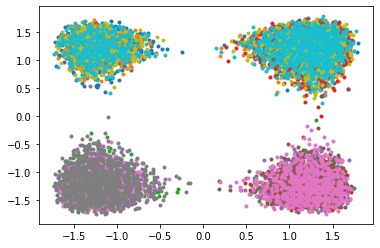

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

os.chdir(path)
try: os.mkdir("Antoniu_2D_potential")
except: print("folder \"Antoniu_2D_potential\" already exists")
os.chdir("Antoniu_2D_potential")


nhills = 500
master = []
all_hills= []
ipos=1.3*(2 * np.random.rand(2) - 1)
FP = np.zeros((200,200))

for simulation in np.arange(0,10): 
    #RUN short sim from random location
    #langevin.run_2D(ipos=ipos,tag=simulation)
    #!plumed pesmd < input  >/dev/null
    #Read the HILLS file
    print('Simulation: '+str(simulation))
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS_"+str(simulation))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name="position_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 1, error_pace = 1, nhills=nhills)
    master.append([Ftot_den, Ftot_x, Ftot_y])
    FP += Ftot_den
    ipos=1.3*(2 * np.random.rand(2) - 1)    

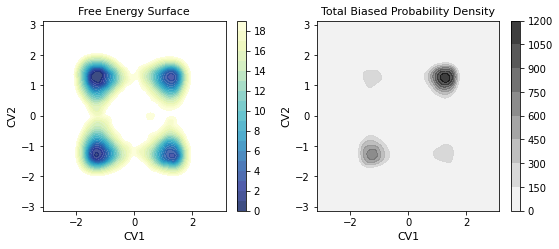

In [8]:
#Patch
[Ftot_den_patch, Ftot_x_patch, Ftot_y_patch] = MFI.patch_2D(master)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_patch, Ftot_y_patch,nbins=(200,200))

# Plot Recap
MFI.plot_patch_2D(X, Y, FES, Ftot_den_patch, lim=20)


Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 11.179675188813977
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 8.319299836336574
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.945473622876131
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 9.12559841057757


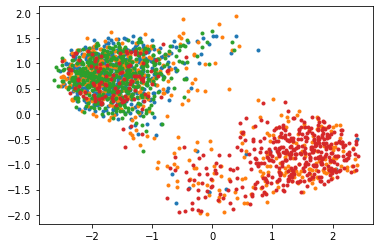

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

os.chdir(path)
try: os.mkdir("Invernizzi_2D_potential")
except: print("folder \"Invernizzi_2D_potential\" already exists")
os.chdir("Invernizzi_2D_potential")

master = []
all_hills= []
ipos=1.3*(2 * np.random.rand(2) - 1)
FP = np.zeros((200,200))

for simulation in np.arange(0,4): 
    #RUN short sim from random location
    #langevin.run_2D_Invernizzi(ipos=ipos,tag=simulation)
    #!plumed pesmd < input  >/dev/null
    #Read the HILLS file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_"+str(simulation))
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.12, kT = 1, log_pace = 1, error_pace = 1, nhills=-1)
    master.append([Ftot_den, Ftot_x, Ftot_y])
    FP += Ftot_den
    ipos=1.3*(2 * np.random.rand(2) - 1)
    

### 2D - Non-periodic case | Invernizzi potential

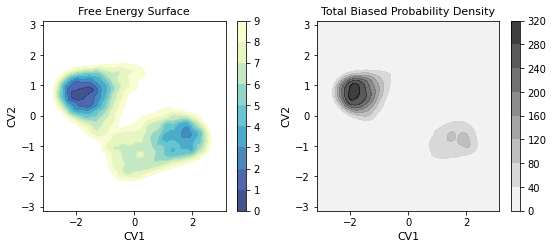

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

[Ftot_den_patch, Ftot_x_patch, Ftot_y_patch] = MFI.patch_2D(master)

#integration on a periodic domain
[X, Y, FES] = MFI.intg_2D(Ftot_x_patch, Ftot_y_patch)

# Plot Recap
MFI.plot_patch_2D(X, Y, FES, Ftot_den_patch,lim=10)
